# Coffee Market Analysis
## Exploratory Data Analysis Notebook (3)

### Matthew Garton - February 2019

**Purpose:** The purpose of this notebook is to perform Exploratory Data Analysis on my coffee dataset, to examine relationships between variables, distributions, and try to determine which variables will be most useful for predicting coffee prices. I started a new notebook to try a different approach. Rather than starting with the full dataset - I want to separate each set of predictors to examine relationships one at a time (Fundamental Data, Weather Data, Technical Data). Once I have figured out the relationships that have value for prediction, then I can incorporate those into a model.

**Context**: The ultimate goal of my project is to develop trading signals for coffee futures. I will attempt to build a machine learning model which uses fundamental and technical data to predict the future direction of coffee futures price changes. My expectation at the outset of this project is that my feature matrix will include data on weather, GDP, and coffee production and exports in major coffee-producing nations, GDP and coffee import data in major coffee-importing nations, as well as volume, open-interest, and commitment of traders data for ICE coffee futures contracts.

This notebook imports a cleaner dataset that I prepared in the Data Wrangling Notebook, called CoffeeDataset. See '../data/' for all of the raw data that I started with, or the links in the Data Wrangling Notebook to get the data directly from the source.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.regression.linear_model import OLS

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import the dataset
coffee = pd.read_csv('../data/CoffeeDataset.csv')
coffee['Date'] = pd.to_datetime(coffee['Date'])
coffee.set_index('Date', inplace=True)

In [3]:
coffee.columns

Index(['Open', 'High', 'Low', 'Settle', 'Volume', 'BRA_Temp', 'BRA_Precip',
       'COL_Precip', 'COL_Temp', 'ETH_Precip', 'ETH_Temp', 'IDN_Precip',
       'IDN_Temp', 'VNM_Precip', 'VNM_Temp', 'Production',
       'Consumption (domestic)', 'Exportable Production',
       'Gross Opening Stocks', 'Exports', 'Imports', 'Re-exports',
       'Inventories', 'Disappearance', 'Open_Interest_All',
       'NonComm_Positions_Long_All', 'NonComm_Positions_Short_All',
       'NonComm_Postions_Spread_All', 'Comm_Positions_Long_All',
       'Comm_Positions_Short_All', 'Tot_Rept_Positions_Long_All',
       'Tot_Rept_Positions_Short_All', 'NonRept_Positions_Long_All',
       'NonRept_Positions_Short_All', 'Pct_of_OI_NonComm_Long_All',
       'Pct_of_OI_NonComm_Short_All', 'Pct_of_OI_NonComm_Spread_All',
       'Pct_of_OI_Comm_Long_All', 'Pct_of_OI_Comm_Short_All',
       'Pct_of_OI_Tot_Rept_Long_All', 'Pct_of_OI_Tot_Rept_Short_All',
       'Pct_of_OI_NonRept_Long_All', 'Pct_of_OI_NonRept_Short_All',
 

## 2) Price and Weather Data

In [4]:
df = coffee[['Settle','BRA_Temp','BRA_Precip', 'COL_Precip',
             'COL_Temp', 'ETH_Precip', 'ETH_Temp', 'IDN_Precip',
             'IDN_Temp', 'VNM_Precip', 'VNM_Temp']].resample('M').last()

In [5]:
df.rename(columns={'Settle':'Price'}, inplace=True)

In [6]:
def get_forward_returns(df, ranges):
    for r in ranges:
        df['{}M_Return'.format(r)] = df['Price'].pct_change(r).shift(-r)

In [26]:
get_forward_returns(df, [1,3,6])

In [11]:
df.dropna(inplace=True)

In [14]:
def plot_series(df, cols, pos=1):
    
    ax1 = fig.add_subplot(5, 2, pos)
    ax1.plot(df[cols[0]].dropna(), color='k', label=cols[0])

    ax2 = ax1.twinx()
    ax2.plot(df[cols[1]].dropna(),color='b', label=cols[1])

    plt.title('{} and {}'.format(cols[0],cols[1]), fontsize=18)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2);

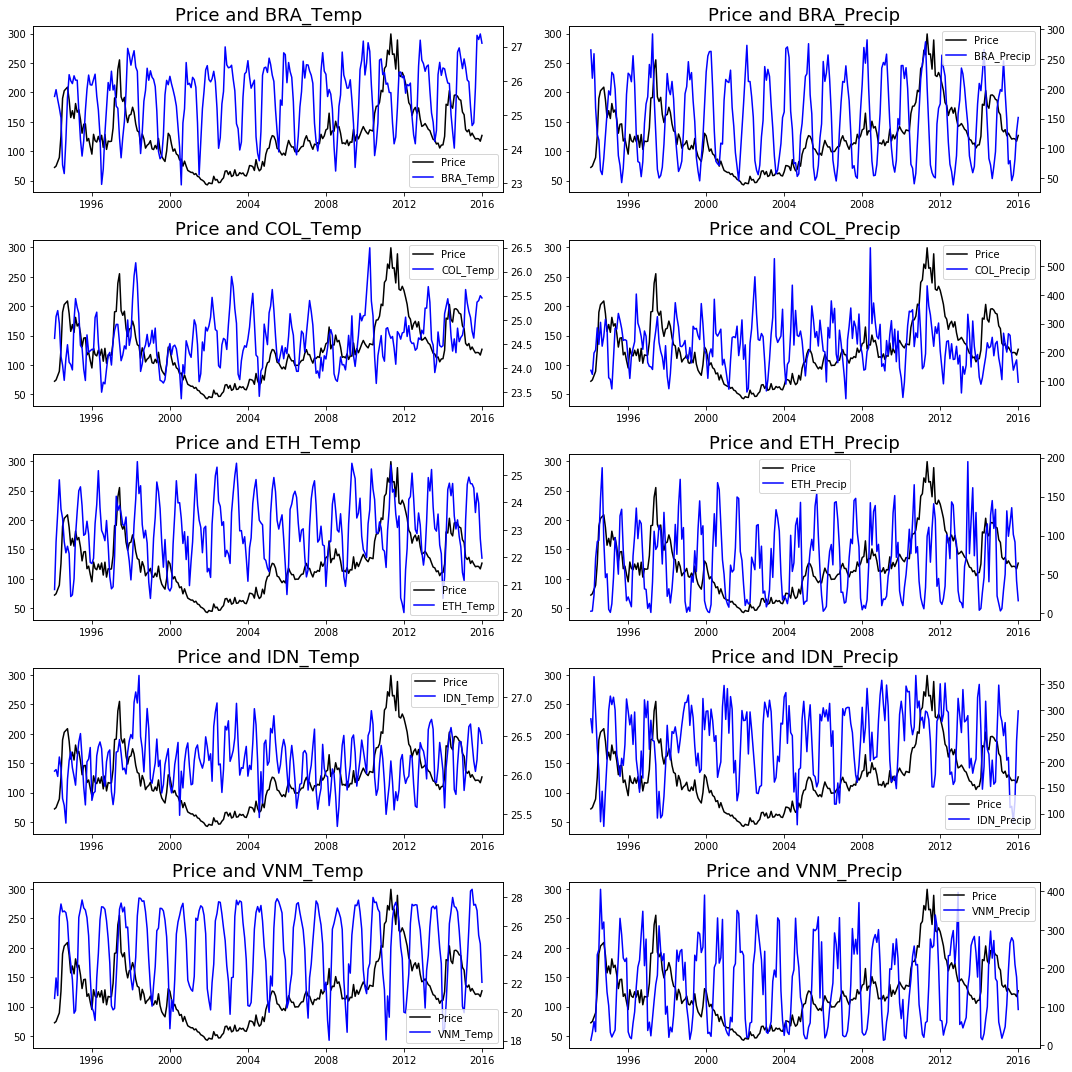

In [20]:
fig = plt.figure(figsize=(15,15))
plot_series(df, cols=['Price','BRA_Temp'])
plot_series(df, cols=['Price','BRA_Precip'], pos=2)
plot_series(df, cols=['Price','COL_Temp'], pos=3)
plot_series(df, cols=['Price','COL_Precip'], pos=4)
plot_series(df, cols=['Price','ETH_Temp'], pos=5)
plot_series(df, cols=['Price','ETH_Precip'], pos=6)
plot_series(df, cols=['Price','IDN_Temp'], pos=7)
plot_series(df, cols=['Price','IDN_Precip'], pos=8)
plot_series(df, cols=['Price','VNM_Temp'], pos=9)
plot_series(df, cols=['Price','VNM_Precip'], pos=10)
plt.tight_layout();

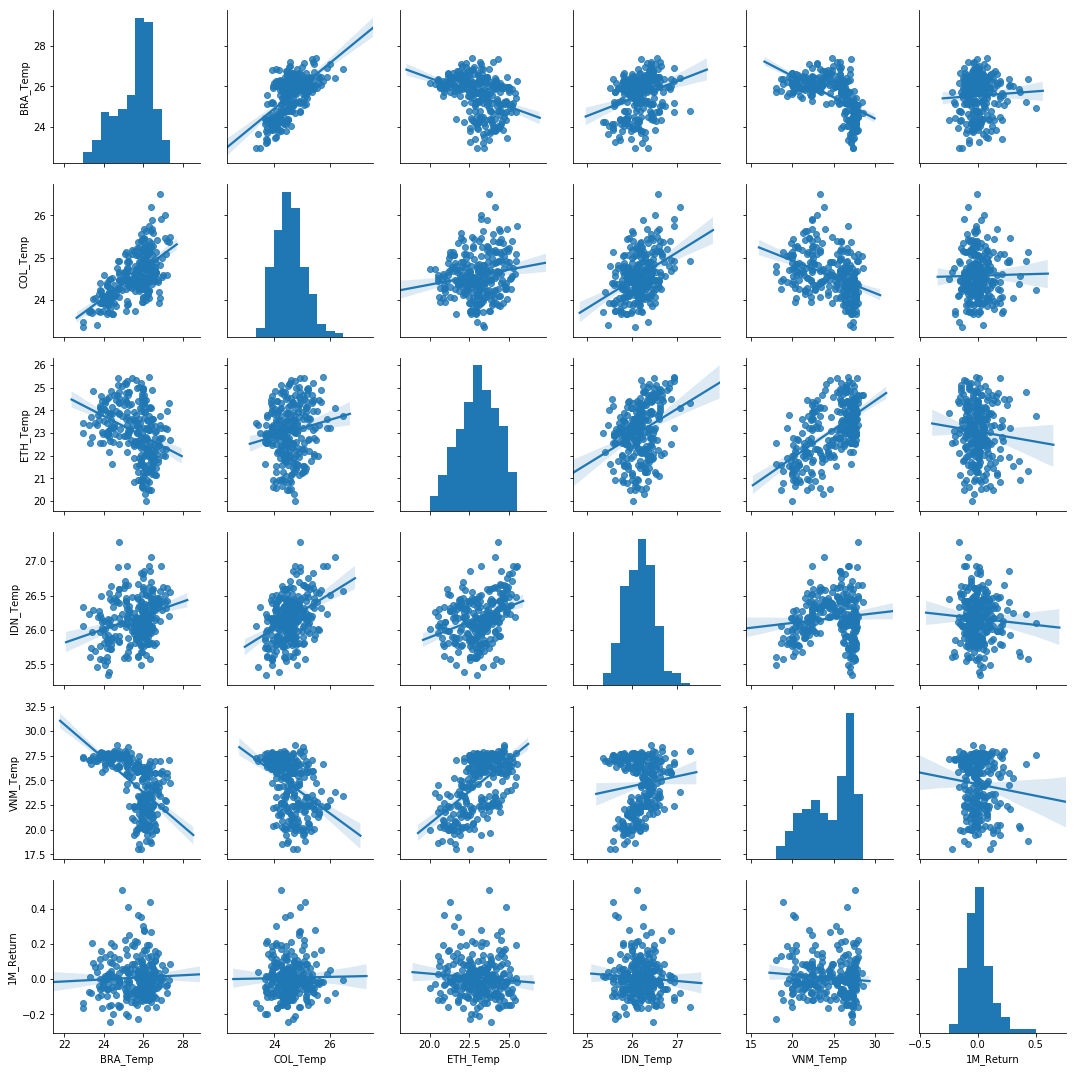

In [27]:
sns.pairplot(vars=['BRA_Temp','COL_Temp', 'ETH_Temp',
                   'IDN_Temp', 'VNM_Temp','1M_Return'], 
             data=df,
             kind='reg');

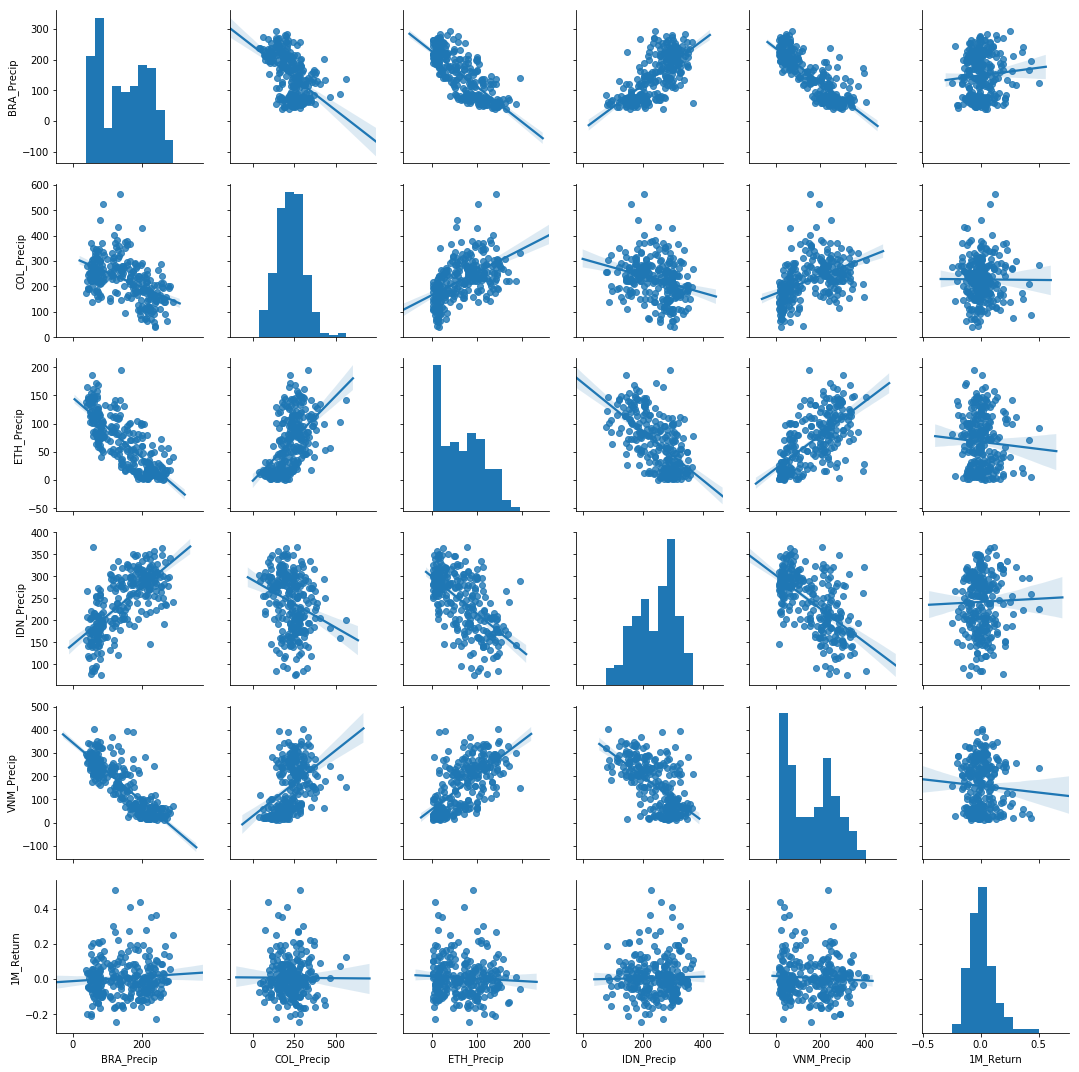

In [28]:
sns.pairplot(vars=['BRA_Precip','COL_Precip', 'ETH_Precip',
                   'IDN_Precip', 'VNM_Precip','1M_Return'], 
             data=df,
             kind='reg');

Note: as it is, the variance in temperature is not explaining the variation in price. I think the strong seasonality (and the fact that I'm not accounting for it) is contributing to the noise. What I plan to do is identify the growing seasons in each country, and create appropriate weather variables for those seasons on an annual frequency. Again, I am running into the difficulty of having a small number of observations.